In [31]:
import numpy as np
import matplotlib.pylab as plt
from ugradio.dft import dft, idft
from scipy.stats import norm, gaussian_kde
import scipy.signal
from sklearn.metrics import r2_score

plt.rcParams.update({'font.size': 20})

def freq_to_period(freq):
    '''take frequency (in kHz)
    and converts to period (in microseconds)'''
    return (1/freq) * 1000

Noise generator (attenuator dial set to 0)
Fed into low pass filter (10 MHz) and then attenuator and then into SDR
nsample = default (2048)
nblocks = 1000

Sample frequency: 3200 kHz

Default anti-aliasing filter is on.

In [25]:
# data
fname = '../data_sec5/all_noise.npy'
all_data = np.load(fname)
all_data.shape

(1000, 2048)

In [45]:
def get_noise_data(num_blocks=1):
    return np.append(np.array([]), all_data[np.random.choice(range(len(all_data)), replace=False, size=num_blocks)])

In [26]:
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

-0.01704293085836639
0.10529820724419206


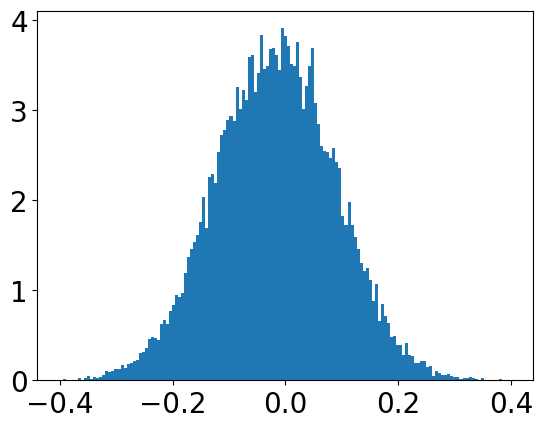

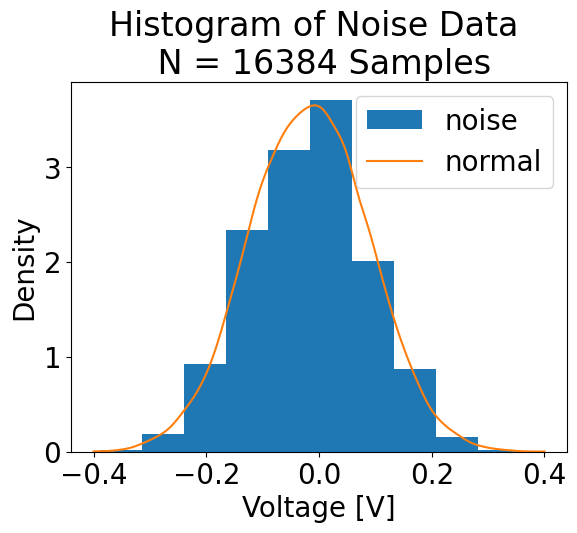

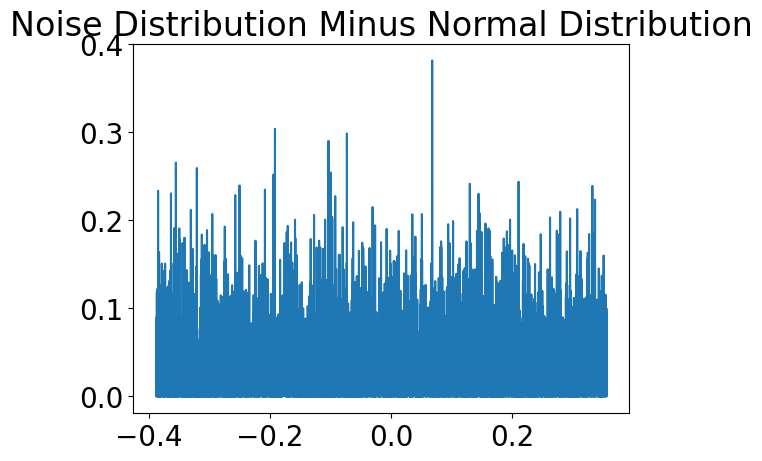

RMSE:  0.15028895015403054
r2 score:  -1.0370990538054614


In [46]:
def hist_plotter():
    size = 8
    
    # data = normalize(np.append(data, all_data[:size]), -1, 1)
    data = get_noise_data(size)
    print(np.mean(data))
    print(np.std(data))
    gauss_data = np.random.normal(np.mean(data) , np.std(data), len(data))

    n, x, _ = plt.hist(gauss_data, bins=np.linspace(-.4, .4, 150), label='normal', density=True)
    plt.show()
    density = gaussian_kde(gauss_data)
    plt.hist(data, label='noise', density=True)
    plt.plot(x, density(x), label="normal")
    plt.legend()
    plt.title("Histogram of Noise Data \n N = " + str(int(2048 * size)) + " Samples")
    plt.ylabel("Density")
    plt.xlabel("Voltage [V]")
    plt.show()

    plt.plot(np.linspace(min(data), max(data), len(data)), (data - gauss_data)**2)
    # plt.yscale('log')
    plt.title('Noise Distribution Minus Normal Distribution')
    plt.show()

    print("RMSE: ", np.sqrt(np.mean((data - gauss_data)**2)))
    print("r2 score: ", r2_score(data, gauss_data))
hist_plotter()

In [28]:
def power(data, vsamp=3200):
    f, Fx = dft(data, vsamp=vsamp)
    return f, np.abs(Fx)**2

Signal Freq = 800 kHz 

Sample Freq = 3200 kHz

In [61]:
def avg_power(num_blocks):
    freqs, all_ps = [], []
    
    for i in np.random.choice(range(len(all_data)), size=num_blocks, replace=False):
        block = all_data[i]
        freqs, ps = power(block)
        # plt.scatter(freqs, ps)
        all_ps += [np.array(ps)]
    # plt.show()

    avg_ps = np.mean(all_ps, axis=0)
    return freqs, avg_ps

def plotter():
    plt.figure()
    plt.plot(freqs, avg_ps)
    plt.title('Avg Power Spectrum \n N = ' + str(num_blocks) + ' Blocks')
    

    # adjust x axis
    # plt.xlim(300, 600) 
    plt.xlabel('Frequency [kHz]')

    # adjust y axis
    plt.yscale("log")
    plt.ylabel('Power')

    plt.grid(visible=True)
    plt.legend()
    plt.show()

# [avg_power(N) for N in [2, 4, 8, 16]]

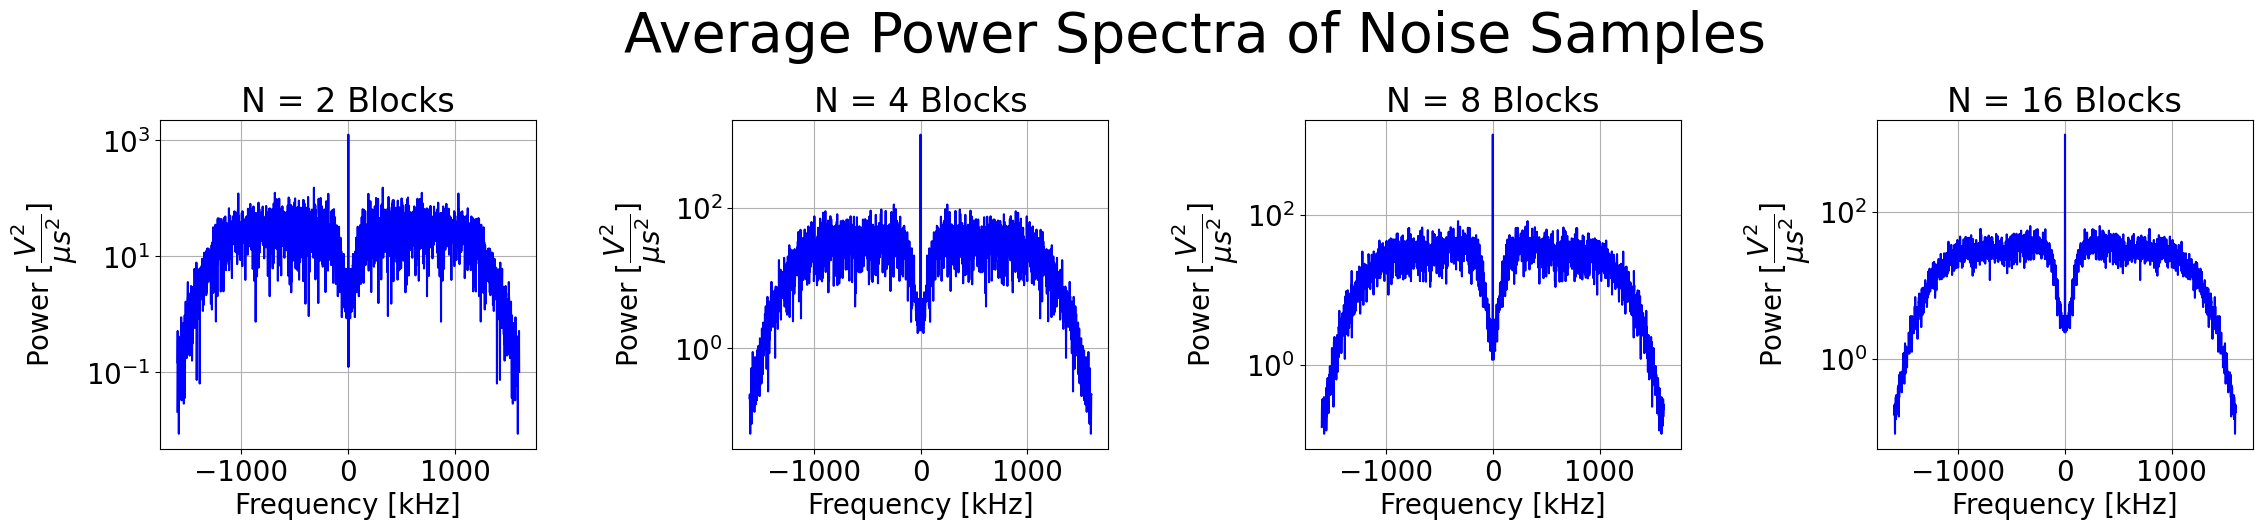

In [68]:
def plot_noise_avg_ps():
    
    # plotter
    plt_N = [2, 4, 8, 16]
    fig, axs = plt.subplots(1, len(plt_N),  figsize=(24, 6))
    fig.tight_layout(pad=4.0)
    fig.suptitle("Average Power Spectra of Noise Samples\n", fontsize=40)
    for i in range(len(plt_N)):
        num_blocks = plt_N[i]
        freqs, ps_data = avg_power(num_blocks)

        # Power
        ps = axs[i]
        ps.plot(freqs, ps_data, color="blue")
        ps.set_title('N = ' + str(num_blocks) + ' Blocks')
        ps.set_xlabel(r'Frequency [kHz]')
        # ps.set_xlim(-1000, 1000)
        ps.set_ylabel('Power [$\dfrac{V^2}{\mu s^2}$]')
        ps.set_yscale('log')
        ps.grid(visible=True)
        # ps.legend()

    plt.show()
plot_noise_avg_ps()

# ACF

In [30]:
def plot_acf():    
    block_data = [i for dataset in all_data[np.random.choice(range(len(all_data)), size=16000//2048+1, replace=False)] for i in dataset]
    fa, F_acf = dft(np.convolve(block_data, block_data), vsamp=3200)
    fa, acf = idft(F_acf, fa, vsamp=3200)

    # power
    fp, ps = power(block_data)
    plt.plot(fp, ps, label="power func")
    plt.plot(fa, np.abs(F_acf), label="acf")
    plt.title('Power Spectrum \n N = ' + str((16000//2048+1)*2048) + ' Samples')
    # plt.xlim(300, 600) 
    plt.xlabel('Frequency [kHz]')
    plt.yscale("log")
    plt.ylabel('Power')
    plt.grid(visible=True)
    plt.legend()
    plt.show()
# plot_acf()

KeyboardInterrupt: 